# INFO-4604/5604 HW4

### Solution by: *Johnny Sreenan* 

#### If you worked with a partner, list the partner here

In this assignment, you will classify the *sentiment* (positive, negative, or neutral) of hotel reviews posted on Yelp. See Chapter 8 of the textbook for more explanation of sentiment classification. The main goal of this assignment is to get practice with feature engineering, feature extraction, and feature selection.

### What to hand in

You will submit the assignment on Canvas. Submit a HTML or PDF version of your notebook named `hw4lastname.pdf` or  `hw4lastname.html`, where lastname is replaced with your last name.

When writing code in this notebook, you are encouraged to create additional cells in whatever way makes the presentation more organized and easy to follow. You are allowed to import additional Python libraries.

### Submission policies

- **Collaboration:** You are allowed to work with a partner. You are still expected to write up your own solution. Each individual must turn in their own submission, and list your collaborator after your name.
- **Late submissions:** We allow each student to use up to 5 late days over the semester. You have late days, not late hours. This means that if your submission is late by any amount of time past the deadline, then this will use up a late day. If it is late by any amount beyond 24 hours past the deadline, then this will use a second late, and so on. Once you have used up all late days, late assignments will be given at most 80% credit after one day and 60% credit after two days.

## Annotated data

The dataset contains 1000 reviews of hotels downloaded from Yelp. Sentiment labels could be one of three classes (positive, negative, neutral). Each review is labeled as:

- **1:** The review expresses a *positive* opinion toward the hotel.
- **0:** The review expresses a mixed or neutral opinion toward the hotel.
- **-1:** The review expresses a *negative* opinion toward the hotel.

In this assignment, you will build classifiers to predict these three classes. The dataset has been prepared for you. A random subset (approximately 10% of the reviews) was selected as test data, while the rest will be used for training. Run the code below to download and extract the data.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('yelp_hotels1000.csv', 
                 header=None, encoding='ISO-8859-1')

df_train = df.loc[df[1] == 'train']
df_test = df.loc[df[1] == 'test']

Y_train = df_train.iloc[0:, 2].values
text_train = df_train.iloc[0:, 3].values

Y_test = df_test.iloc[0:, 2].values
text_test = df_test.iloc[0:, 3].values

## Setting up the classifier

### Tokenization and feature extraction

The first step is to convert the raw text into feature vectors. In Ch. 8 of the book, and in HW2, the class [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) is presented as a way to convert text strings into `sklearn` feature vectors. This class can automatically perform tokenization (doing preprocessing steps we talked about in class, including lowercasing and stripping punctuation). However, for this assignment, we aren't going to use `CountVectorizer`, though it is useful to know about. We will instead write our own code to do tokenization and feature extraction. This will allow us to modify the features, which you will need to do later, plus it will let you see how feature extraction is done.

The code below defines our feature extraction function, `features`. It takes a text string and it outputs a Python dictionary where the keys are the feature names and the values are the feature values. This is a _sparse_ representation, meaning it only outputs features with nonzero value.

By default, the features extracted by this function are n-gram counts. The keyword argument `ngram_range` specifies the length of n-grams to extract. This argument should be a pair of integers, where the first integer is the lower end of the length to be extracted and the second integer is the upper end. For example, `ngram_range=(1,3)` will extract 1-grams, 2-grams, and 3-grams, while `ngram_range=(2,2)` will extract only 2-grams.

The function performs two initial preprocessing steps: making the text lowercase (so different capitalizations of words will map to the same feature), and removing consecutive characters that are repeated more than twice (e.g., "woooow" and "wooooooooow" will both map to simply "woow" rather than being counted as separate words).

The function tokenizes words as follows. First, non-alphanumeric characters are replaced with whitespace, then strings separated by whitespace are treated as tokens. Python's `split` function converts a string into a list of tokens that were separated by whitespace. The list of tokens is passed to the `ngrams` function, defined below, which returns a list of all n-grams of length `n` contained in the list. Finally, the function also pulls out tokens containing anything _but_ alphanumeric characters. This will capture punctuation marks and emojis, which may also be useful for classification. These are treated as unigram features rather than longer sequences.

For now, simply run the code below. However, you'll need to modify this code later, so you need to understand what it is doing.

In [49]:
import re
from collections import Counter

def ngrams(tokens, n):
    output = []
    for i in range(n-1, len(tokens)):
        ngram = ' '.join(tokens[i-n+1:i+1])
        output.append(ngram)
    return output

def features(text, ngram_range=(1,1)):
    text = text.lower()      # make the string lowercase
    text = re.sub(r'(.)\1+', r'\1\1', text)     # remove consecutive characters that are repeated more than twice
    
    features_in_text = []   # running list of all features in this instance (can be repeated)
    
    # treat alphanumeric characters as word tokens (removing anything else),
    # and extract all n-grams of length n specified by ngram_range
    
    text_alphanum = re.sub('[^a-z0-9]', ' ', text)
    for n in range(ngram_range[0], ngram_range[1]+1):
        features_in_text += ngrams(text_alphanum.split(), n)
    
    # now treat punctuation as word tokens, and get their counts (only unigrams)
    
    text_punc = re.sub('[a-z0-9]', ' ', text)
    features_in_text += ngrams(text_punc.split(), 1)
    
    # 'Counter' converts a list into a dictionary whose keys are the list elements 
    #  and the values are the number of times each element appeared in the list
    
    return Counter(features_in_text)


To get a better understanding of what the `features` function is returning, see what happens on the example text when you run the code below. The `ngram_range` is set to `(1,2)` which means it will extract both 1-grams and 2-grams. You should notice that it extracts all words (separated by punctuation) and two-word phrases, with counts based on how often they appear (e.g., "`a sentence`" is a 2-gram that appears twice). Also note that punctuation is also counted (but only as 1-grams, not 2-grams), and notice that "`!!`" has a count of 2 because "!!!" was rewritten as "!!".

You may find it helpful to change the text and/or the n-gram range to see what features are extracted.

In [3]:
text = "This is an example of a sentence to tokenize!! Actually, it's more than a sentence, it's two sentences!!!"

print(features(text, ngram_range=(1,2)))

Counter({'a': 2, 'sentence': 2, 'it': 2, 's': 2, 'a sentence': 2, 'it s': 2, '!!': 2, ',': 2, "'": 2, 'this': 1, 'is': 1, 'an': 1, 'example': 1, 'of': 1, 'to': 1, 'tokenize': 1, 'actually': 1, 'more': 1, 'than': 1, 'two': 1, 'sentences': 1, 'this is': 1, 'is an': 1, 'an example': 1, 'example of': 1, 'of a': 1, 'sentence to': 1, 'to tokenize': 1, 'tokenize actually': 1, 'actually it': 1, 's more': 1, 'more than': 1, 'than a': 1, 'sentence it': 1, 's two': 1, 'two sentences': 1})


Finally, we need to extract features from all of the training instances and convert them into a feature vector representation to be used by `sklearn`. The code below takes the output of the `features` function (with only 1-grams for this example, though you will change this later), then maps all the feature strings into integers, then defines `X_train` as a sparse array that encodes the values of each feature in each instance. Like in HW2, the [`DictVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) is used to do this conversion. 

In [4]:
from sklearn.feature_extraction import DictVectorizer

vect = DictVectorizer()
X_train = vect.fit_transform(features(d, ngram_range=(1,1)) for d in text_train)
print(X_train)

  (0, 42)	5.0
  (0, 46)	1.0
  (0, 58)	1.0
  (0, 68)	5.0
  (0, 78)	11.0
  (0, 233)	1.0
  (0, 418)	4.0
  (0, 433)	2.0
  (0, 521)	1.0
  (0, 616)	1.0
  (0, 633)	1.0
  (0, 643)	2.0
  (0, 656)	3.0
  (0, 681)	1.0
  (0, 684)	9.0
  (0, 765)	1.0
  (0, 788)	4.0
  (0, 843)	1.0
  (0, 867)	1.0
  (0, 1010)	1.0
  (0, 1023)	1.0
  (0, 1065)	3.0
  (0, 1084)	2.0
  (0, 1163)	1.0
  (0, 1177)	1.0
  :	:
  (889, 7267)	1.0
  (889, 7456)	1.0
  (889, 7641)	1.0
  (889, 7877)	1.0
  (889, 7955)	2.0
  (889, 8085)	1.0
  (889, 8089)	6.0
  (889, 8118)	1.0
  (889, 8141)	1.0
  (889, 8184)	1.0
  (889, 8188)	1.0
  (889, 8205)	3.0
  (889, 8522)	1.0
  (889, 8603)	1.0
  (889, 8648)	1.0
  (889, 8763)	1.0
  (889, 8767)	1.0
  (889, 8792)	3.0
  (889, 8798)	1.0
  (889, 8806)	2.0
  (889, 8818)	2.0
  (889, 8863)	1.0
  (889, 8874)	1.0
  (889, 8880)	1.0
  (889, 8883)	1.0


### Classifier and hyperparameter tuning

In this assignment, we will use multinomial logistic regression as our classifier. Recall that logistic regression outputs probabilities, and the multinomial version can handle more than two classes. Mulinomial logistic regression is also called a "maximum entropy" or "MaxEnt" classifier.

We will use `sklearn`'s [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class, setting the `multi_class` argument to `'multinomial'` which tells it to use the multinomial version (otherwise it defaults to binary logistic regression with a one-vs-rest scheme for multiclass data).

The `LogisticRegression` class uses the argument `C` to denote the regularization strength (same as in the `SVC` class you used in HW3). It is important to adjust this hyperparameter to get good performance.

`sklearn` has a class, [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) for tuning a classifier with cross-validation. When you construct a `GridSearchCV` object, you supply the set of parameters and their possible values that you would like to adjust. During training, it will perform cross-validation with every combination of parameter values, then train a final classifier using the best-performing settings. In the code, only a small number of values are listed, because it would be too slow to try many combinations. This code might take a few minutes to run on your machine.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score

# this defines the classifier we will use -- don't change this variable

base_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', tol=1e-2, max_iter=500, random_state=123)

# these are the C values we will compare -- don't change this variable

params = [{'C': [0.01, 0.1, 1.0]}]

# this performs 2-fold cross-validation with the above classifier and parameter options

gs_classifier = GridSearchCV(base_classifier, params, cv=2)
gs_classifier.fit(X_train, Y_train)

print(gs_classifier.get_params())
print("Best parameter settings:", gs_classifier.best_params_)
print("Validation accuracy: %0.6f" % gs_classifier.best_score_)

{'cv': 2, 'error_score': nan, 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 500, 'estimator__multi_class': 'multinomial', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': 123, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.01, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(max_iter=500, multi_class='multinomial', random_state=123,
                   tol=0.01), 'n_jobs': None, 'param_grid': [{'C': [0.01, 0.1, 1.0]}], 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}
Best parameter settings: {'C': 0.1}
Validation accuracy: 0.737079


In the code above, calling `gs_classifier.fit` will perform cross-validation for all parameter settings. Once it finishes, then `gs_classifier` can be used as any other classifier object, so you can call the `predict` or `predict_proba` functions to make classifications, just as you did in HW3. As you can see in the code above, the object also contains variables that will give you the optimal parameters and cross-validation accuracy.

## Problem 1: Feature Choice and Selection [7 points]

We will begin by experimenting with different feature sets, where we modify the feature set in two ways. First, we will experiment with different sizes of n-grams. Second, we will experiment with automated feature selection.

### N-gram size

As you saw above, the `features` function takes a keyword argument, `ngram_range`, that let's you specify the sizes of n-grams to extract. Experiment with six different ranges of n-gram sizes: (1,1), (2,2), (3,3), (1,2), (1,3), (2,3)

For each n-gram range, you'll need to re-extract and vectorize the features (calling the `features` and `vect.fit_transform` functions, as done above). For each setting, calculate the cross-validation accuracy with `best_score_` when $C=.1$. (In practice, you might want to tune $C$ for each ngram feature size. But this takes too long for a homework assignment.) 



In [6]:
#### Deliverable 1.1: Fill in the table below with the cross-validation accuracy when using each range of n-grams.
#### To fill out the table, you will need to modify the cell below

In [7]:
### Modify this code to test out different ngram ranges

# This code will take a few minutes to run

params = [{'C': [.1]}]

vect = DictVectorizer()
# G = [(1,1), (2,2), (3,3), (1,2), (1,3), (2,3)]
ng = (2,2)

X_train = vect.fit_transform(features(d, ngram_range=ng) for d in text_train)

base_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=.1, max_iter=300, tol=1e-2, random_state=123)

gs_classifier = GridSearchCV(base_classifier, params, cv=2)
gs_classifier.fit(X_train, Y_train)
print(gs_classifier)
print(ng)
print("Validation accuracy: %0.6f" % gs_classifier.best_score_)    
    

GridSearchCV(cv=2,
             estimator=LogisticRegression(C=0.1, max_iter=300,
                                          multi_class='multinomial',
                                          random_state=123, tol=0.01),
             param_grid=[{'C': [0.1]}])
(2, 2)
Validation accuracy: 0.675281


In [8]:
### Modify this code to test out different ngram ranges

# This code will take a few minutes to run

params = [{'C': [.1]}]

vect = DictVectorizer()
G = [(1,1), (2,2), (3,3), (1,2), (1,3), (2,3)]
ng = (2,2)
#Loop through G to test different ngram ranges
for g in G:
    X_train = vect.fit_transform(features(d, ngram_range=g) for d in text_train)

    base_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=.1, max_iter=300, tol=1e-2, random_state=123)

    gs_classifier = GridSearchCV(base_classifier, params, cv=2)
    
    gs_classifier.fit(X_train, Y_train)
    print(g)
    print("Validation accuracy: %0.6f" % gs_classifier.best_score_)    
    

(1, 1)
Validation accuracy: 0.737079
(2, 2)
Validation accuracy: 0.675281
(3, 3)
Validation accuracy: 0.606742
(1, 2)
Validation accuracy: 0.725843
(1, 3)
Validation accuracy: 0.721348
(2, 3)
Validation accuracy: 0.651685


| N-grams | Validation accuracy |
|---------|---------------------|
| (1,1)   |0.737079             |
| (2,2)   |0.675281             |
| (3,3)   |0.606742             |
| (1,2)   |0.725843             |
| (1,3)   |0.721348             |
| (2,3)   |0.651685             |


# Deliverable 1.2: 
## Describe what you observe with different length n-grams. 

**The first thing I noticed about different n-grams is that the ranges that started with 1, yeilded higher validation accuracy. The 3 highest accuracies come from ranges that start with 1.**

### When using only one type of n-gram (1, 2, or 3), how does the length affect accuracy? 

**When using n-gram = 1, I noticed that this was the highest training accuracy out of all of the options. I also observed that as you increased your n-gram from 1 to 2 to 3, the validation accuracy becomes less accurate.**

### How does using only one size of n-gram (1, 2, or 3) compare to using a range of different sizes (1-2, 1-3, or 2-3)?

**While the highest validation accuracy comes from a n-gram size of 1, generally the highest accuracy came from using a range of different sizes.**


### Feature selection

Selecting a subset of features can improve classifier efficiency and potentially guard against overfitting. However, it can also hurt performance if too many features are removed. We will now experiment with different levels of feature selection.

We will use the [`SelectPercentile`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html) class, which can be used to select features that are within a specified percentile according to a scoring function that ranks the quality of the features. The code below instantiates a `SelectPercentile` object using the [`chi2`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) function, which performs a chi-squared test for measuring the significance of features. The `percentile` argument specifies the percentile of features that are selected after ranking by their chi-squared statistic. If `percentile=1`, only the top 1% of features will be selected. If `percentile=100`, all features will be selected.

Once you've created a `SelectPercentile` object, its `fit` function can be called to calculate the significance of the features, and its `transform` function will modify the feature vectors to choose only the selected features. The `fit_transform` function performs both of these steps, which is what you see below.

Experiment with different feature selection percentiles to see how the training accuracy is affected by different settings.

#### Deliverable 1.3: Calculate the cross-validation accuracy at different values of `percentile`, when the percentile is each of $[1, 5, 20, 50, 100]$. Create a plot where the percentile is on the x-axis and the cross validation accuracy is on the y-axis (again, accessible via the `best_score_` attribute). Do this using n-gram ranges of (1,3).

[your code for this should be below]


In [9]:
from sklearn.feature_selection import SelectPercentile, chi2

# example: feature selection at the 60th percentile.
# Note the renaming of the feature vectors to X_train_selected
val_acc = []
params_feat = [{'C': [.1]}]

P = [1,5,20,50,100]
for p in P:
    base_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=300, tol=1e-2, random_state=123)

    selection = SelectPercentile(percentile=p, score_func=chi2)

    
    X_train_3g = vect.fit_transform(features(d, ngram_range=(1,3)) for d in text_train)

    X_train_selected = selection.fit_transform(X_train_3g, Y_train)
    gs_classifier.fit(X_train_selected, Y_train)
    # fit classifier on selected train data
#     print(X_train_selected)
    val_acc.append(gs_classifier.best_score_)

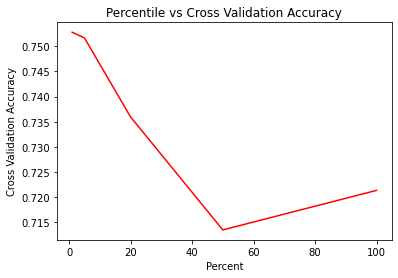

In [10]:
import matplotlib.pyplot as plt
plt.title('Percentile vs Cross Validation Accuracy')
plt.xlabel('Percent')
plt.ylabel('Cross Validation Accuracy')


plt.plot(P, val_acc, 'r-') 


# plt.legend()
plt.show()


#### Deliverable 1.4: Describe what you observe in the 1.3 plots. 
##### Comment on any general patterns that you see and explain why you think this behavior happens.

**The first thing I noticed about this graph is that the lower percentages carry most of the weight. From this I can infer that a small set of features are making a lot of noise in this dataset. It's likely that a small set of certain words allow for easier classification. Another interesting aspect of this graph I noticed is how it starts to go up again in accuracy as you get towards 100%. I think this happens because as you become more inclusive you have filler words that might be common in all of the texts. This can be misleading and I think if we removed the filler words, we would not see this slight increase in accuracy.**


## Problem 2: Feature Engineering [3 points; +6 EC possible]

### Choosing final hyperparameters

Above, you experimented with various ranges of n-grams and feature selection percentiles. For the remainder of this assignment, you should stick with one setting of n-gram range and percentile.

In the code below, the variables `ngr` and `per` define the n-gram range and percentile that you will use in the remaining experience. Currently, `ngr` is set to $(1,3)$ and `per` is set to $100$, but you should modify these values as needed and set them to whatever values gave you the best validation accuracy in your experiments in Problem 1.

In [11]:
ngr = (1,3)
per = 5

Since we are no longer tuning the hyperparameters, now is a reasonable time to also look at the test data. The code below calculates both the cross-validation as well as the accuracy on the test data using the best classifier from cross-validation, using the randomly chosen n-gram and percentile settings. 

You don't need to do anything in this section except understand and run the code in the cell below.

In [12]:
X_train_final = vect.fit_transform(features(d, ngram_range=ngr) for d in text_train)
X_test_final = vect.transform(features(d, ngram_range=ngr) for d in text_test)

selection = SelectPercentile(percentile=per, score_func=chi2)
X_train_final = selection.fit_transform(X_train_final, Y_train)
X_test_final = selection.transform(X_test_final)

gs_classifier = GridSearchCV(base_classifier, params, cv=2)
gs_classifier.fit(X_train_final, Y_train)

print("Validation accuracy: %0.6f" % gs_classifier.best_score_)
print("Test accuracy: %0.6f" % accuracy_score(Y_test, gs_classifier.predict(X_test_final)))

Validation accuracy: 0.751685
Test accuracy: 0.718182


### Creating new features

You will now expand the feature set by implementing a new type of feature. You get to choose which type of feature to implement, from a set of three possibilities described below.

- **4604 students:** You must implement one of the three types of features for full credit. You will earn 3 extra credit points for each additional type of feature that you correctly implement (up to 6 EC points possible).
- **5604 students:** You must implement two of the three types of features for full credit. You will earn 3 extra credit points for additionally implementing the third feature type.

How do you add new features? You will need to create a new feature extraction function. Start by copying the definition of the `features` function at the start of this notebook and renaming it. Keep everything from the original function, but write additional code that appends your new features to the `features_in_text` array. You can create any additional helper functions as needed.

The description of each feature type is below. Be sure to read the instructions carefully.

- **Skip-grams:** A type of feature that is related to an n-gram is a _skip-gram_. Skip-grams can be defined in different ways, but the definition you will use here is a sequence of word tokens where only the first and last word are specified, while any word token in between is replaced with a general placeholder symbol (usually an asterisk, $*$). For example, the string "the water is cold" contains two length-3 skip-grams ("`the * is`" and "`water * cold`") and one length-4 skip-gram ("`the * * cold`"). The purpose of skip-grams is to capture longer sequences while being general enough to match more instances than with longer n-grams. To implement a skip-gram of length $k$, you can simply extract $k$-grams (i.e., n-grams of length $k$) and replace the inner tokens with asterisks. Like with the n-gram features, the values of the skip-gram features should be their counts. For this assignment, you should extract skip-grams of both length 3 and length 4.
- **Word pairs:** It may be helpful to encode combinations of words that appear in a document, regardless of whether they appear in a particular sequence. One type of feature is to indicate if two words are both present in a text (like doing an *AND* operation on the presense of the two unigrams). For example, the string "the water is cold" contains 6 distinct word pairs ("`(the,water)`", "`(the,is)`", "`(the,cold)`", "`(water,is)`", "`(water,cold)`", "`(is,cold)`"). For full credit, your code should not include pairs that are permutations of each other $-$ for example, include `(water,cold)` or `(cold,water)` but not both. An easy way to do this is to sort the words in alphabetical order within pairs. For this feature, simply use the value $1$ if the pair is present in a text and $0$ otherwise (that is, binary values rather than using full counts).
- **Sentiment dictionary:** One might also take advantage of external resources others have created for sentiment analysis. For this type of feature, we will use a sentiment *lexicon* created by researcher [Bing Liu](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), which is a list of words that have a tendency to show positive sentiment and a list of words with negative sentiment. The lexicon contains thousands of words; the words are already loaded for you in the code cell below. For this feature, you should extract n-grams (using whatever n-gram range was randomly selected above) where any word that appears in the positive dictionary is replaced with the capitalized string "`POS`" and any word in the negative dictionary is replaced with the string "`NEG`". For example, the word "cold" is in the negative dictionary, so the string "the water is cold" should have five unigrams all with value $1$ ("`the`", "`water`", "`is`", "`cold`", "`NEG`"), and four bigrams with value with $1$ ("`the water`", "`water is`", "`is cold`", "`is NEG`").

After writing your new function, you should test the function on a few example strings to see if it is extracting features in the way you expect.

In [48]:
# def features(text, ngram_range=(1,1)):
#     text = text.lower()      # make the string lowercase
#     text = re.sub(r'(.)\1+', r'\1\1', text)     # remove consecutive characters that are repeated more than twice
    
#     features_in_text = []   # running list of all features in this instance (can be repeated)
    
#     # treat alphanumeric characters as word tokens (removing anything else),
#     # and extract all n-grams of length n specified by ngram_range
    
#     text_alphanum = re.sub('[^a-z0-9]', ' ', text)
#     for n in range(ngram_range[0], ngram_range[1]+1):
#         features_in_text += ngrams(text_alphanum.split(), n)
    
#     # now treat punctuation as word tokens, and get their counts (only unigrams)
    
#     text_punc = re.sub('[a-z0-9]', ' ', text)
#     features_in_text += ngrams(text_punc.split(), 1)
    
#     # 'Counter' converts a list into a dictionary whose keys are the list elements 
#     #  and the values are the number of times each element appeared in the list
#     print(features_in_text)
#     return Counter(features_in_text)
# features("I am a person today", (3,5))

In [14]:
## If you are using the third feature type (sentiment dictionary),
## run this block of code.

# (original source: http://www.cs.uic.edu/~liub/FBS/opinion-lexicon-English.rar )

sentiment_df = pd.read_csv('sentiment-words.csv', header=None, encoding='ISO-8859-1')

# The two variables, positive_words and negative_words, are sets that contain the positive/negative words

positive_words = sentiment_df.loc[sentiment_df[0] == 'positive']
positive_words = set(positive_words.iloc[0:, 1].values)

negative_words = sentiment_df.loc[sentiment_df[0] == 'negative']
negative_words = set(negative_words.iloc[0:, 1].values)

In [15]:

# ngramskip(['i am a', 'am a sinister', 'a sinister dog', 'i am a sinister', 'am a sinister dog', 'i am a sinister dog'])

#### Deliverable 2.1: Say which feature(s) you implemented.  If you were unable to fully implement it, describe what you attempted to do, and any challenges you ran into. 

# 2.1 Skip Gram implementation

In [16]:
def ngramskip(ngram):
    skipgram = []
    words = []
    skipword = ""
    # grabs the item number and middle texts of the sentence
    for no, string in enumerate(ngram):
#         print(string)
        words.append(string.split())
#     print(words)
    for skip in words:
        skipword = (skip)
        length = len(skipword)
#         print(skipword)
        for itemno, word in enumerate(skipword[0:-1]):
            if itemno == 0:
                skipgram.append(word)
            else:
                skipgram.append('*')
        skipgram.append(skipword[-1])
#     print(skipgram)
    fullgram = " ".join(skipgram)
    return fullgram

def skip_gram_features(text, ngram_range=(1,1)):
    skip = []
    text = text.lower()      # make the string lowercase
    text = re.sub(r'(.)\1+', r'\1\1', text)     # remove consecutive characters that are repeated more than twice
    skipped = []
    features_in_text = []   # running list of all features in this instance (can be repeated)
    
    # treat alphanumeric characters as word tokens (removing anything else),
    # and extract all n-grams of length n specified by ngram_range
    
    text_alphanum = re.sub('[^a-z0-9]', ' ', text)
    for n in range(ngram_range[0], ngram_range[1]+1):
        features_in_text += ngrams(text_alphanum.split(), n)
    
    # now treat punctuation as word tokens, and get their counts (only unigrams)
    
    text_punc = re.sub('[a-z0-9]', ' ', text)
    features_in_text += ngrams(text_punc.split(), 1)
#     print(features_in_text)
    # 'Counter' converts a list into a dictionary whose keys are the list elements 
    #  and the values are the number of times each element appeared in the list
    skipped.append(ngramskip(features_in_text))
    return Counter(skipped)
# skip_gram_features("I am a person today", (3,5))

In [17]:
# If you implemented skip_gram_features uncomment the next line and run the code to show the output from your function
skip_gram_features('I am a sinister dog', (3,5))

Counter({'i * a am * sinister a * dog i * * sinister am * * dog i * * * dog': 1})

# 2.1 Word Pair implementation

In [44]:
from itertools import tee
# combinations function taken from https://docs.python.org/3/library/itertools.html#itertools.combinations
def combinations(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield tuple(pool[i] for i in indices)


def word_pair_features(text, ngram_range=(1,1)):
    text = text.lower()      # make the string lowercase
    text = re.sub(r'(.)\1+', r'\1\1', text)     # remove consecutive characters that are repeated more than twice
    
    features_in_text = []   # running list of all features in this instance (can be repeated)
    
    # treat alphanumeric characters as word tokens (removing anything else),
    # and extract all n-grams of length n specified by ngram_range
    
    text_alphanum = re.sub('[^a-z0-9]', ' ', text)
    for n in range(ngram_range[0], ngram_range[1]):
        features_in_text += ngrams(text_alphanum.split(), n)
#         print(features_in_text)
#         print(a)
        return Counter(combinations(features_in_text, r=2))
# word_pair_features("I am a person today", (1,2))

In [45]:
# If you implemented word_pair_features uncomment the next line and run the code to show the output from your function
word_pair_features('I am a sinister dog', (1,2))

Counter({('i', 'am'): 1,
         ('i', 'a'): 1,
         ('i', 'sinister'): 1,
         ('i', 'dog'): 1,
         ('am', 'a'): 1,
         ('am', 'sinister'): 1,
         ('am', 'dog'): 1,
         ('a', 'sinister'): 1,
         ('a', 'dog'): 1,
         ('sinister', 'dog'): 1})

In [34]:
# If you implemented sentiment_features uncomment the next line and run the code to show the output from your function
# sentiment_features('I am a sinister dog', (1,2))


#### Deliverable 2.2: Calculate the 2-fold cross-validation accuracy and test accuracy using your new feature set. Compare the new accuracies with the accuracies in the code cell above, before you changed the features. Your new features may help, hurt, or make no change to the accuracy. In any case, give a possible explanation for why it affected (or didn't affect) the accuracy.

##### For this deliverable, use an ngram range of (3,5). This is implemented for you below


In [55]:
# code for 2.1-2.2 here

# You should be able to use the code below as-is, except replace the call to the "features" function 
# in the first two lines with a call to the new function that you need to create

# sentiment_features

ngr = (3,5)

X_train_final = vect.fit_transform(skip_gram_features(d, ngram_range=ngr) for d in text_train)
X_test_final = vect.transform(skip_gram_features(d, ngram_range=ngr) for d in text_test)

selection = SelectPercentile(percentile=per, score_func=chi2)
X_train_final = selection.fit_transform(X_train_final, Y_train)
X_test_final = selection.transform(X_test_final)

gs_classifier = GridSearchCV(base_classifier, params, cv=5)
gs_classifier.fit(X_train_final, Y_train)

# Could not get the code to work with the test_acc line of code
# test_acc = np.mean(Y_test == gs_classifier.predict(X_test_final))
print("Validation accuracy: %0.6f" % gs_classifier.best_score_)
print("Test accuracy: %0.6f" % accuracy_score(Y_test,gs_classifier.predict(X_test_final)))

Validation accuracy: 0.577528
Test accuracy: 0.500000


# 2.2 

## Features Function
**Validation Accuracy = 0.660674** -- Highest Validation Accuracy

**Test accuracy: 0.572727** -- Highest Testing Accuracy

## word_pair_features Function
**Validation Accuracy = 0.608989**

**Test accuracy: 0.509091**

## skip_gram_features Function
**Validation Accuracy = 0.577528**

**Test accuracy: 0.500000**

**From comparing the testing and training accuracy of my different feature function, I learned that the original Features function performed the best in both categories. I think the reason behind this is these my new features function had to create generalizations of of less text from the yelp reviews. It's possible that that potentially important keywords are missed in skip_gram_features for example, because many words are replaced.**